In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118  # Cambiar cu118 por la versión de Cuda del sistema
!pip install ipywidgets widgetsnbextension torchsummary einops tqdm matplotlib
!pip install -U "jax[cuda12]"  # Cambiar cuda11 por la versión de nuestro CUDA
!pip install flax
!pip install -q clu

# PRÁCTICA 5: REDES NEURONALES CON COMPONENTES FÍSICOS

En esta práctica vamos a ver como combinar componentes entrenables (como las capas densas y convolucionales) con componentes no entrenables con el objetivo de guiar en el entrenamiento de una red neuronal aprovechando nuestro conocimiento sobre un determinado problema.

Para ello, definiremos y entrenaremos una red que aprenderá a deshacer una transformada de Fourier. Veremos que la red no necesita aprender el proceso de transformación e inversión completos gracias a la posibilidad de guiarla usando nuestro manejo de esta transformada.

En primer lugar, importaremos las librerías que necesitaremos para definir la red:

In [17]:
from torchvision.transforms.v2 import ElasticTransform
!jupyter nbextension enable --py widgetsnbextension

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [18]:
import os
import shutil
import math

# Librerías de PyTorch
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F

# Torch vision para descargar y preprocesar el conjunto de datos que usaremos para entrenar la red
from torchvision import transforms
from torchvision.transforms.functional import rgb_to_grayscale, invert

# Herramientas adicionales para la visualización de los datos y resultados
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

En segundo lugar haremos una serie de comprobaciones para determinar si podemos usar o no una GPU para entrenar la red. El uso de GPU en entrenamiento es altamente recomendable por no decir necesario para que los tiempos de ejecución sean asumibles.

También aprovecharemos para definir una serie de parámetros de configuración para nuestra red:
   - **Batch size**: Por normal general, los conjuntos de datos usados para entrenar una red neuronal tienen un gran tamaño. Esto impide que podamos cargar todos estos datos directamente en nuestra GPU. Por ello, es una práctica común entrear la red en un "subconjunto" de los datos más pequeño, calcular los gradientes y optimizar los parámetros de la red. El tamaño de este subconjunto es conocido como "batch size" y suele estar comprendido entre 8 y 1024 (aumentando generalmente en potencias de 2).
   - **Epochs**: El paso de todas los lotes que componen el conjunto de datos por la red neuronal se conoce como una epoch. Es decir, cuando se completa una epoch la red ha visto el conjunto de datos completo. Generalmente, una sola epoch no es suficiente para entrenar una red neuronal, por lo que se suele recorre el conjunto de datos de entrada varias veces hasta que la red se ha optimizado por completo. El número total de veces que se recorre un dataset/epochs es un parámetro más a definir en nuestra red.
   - **Learning rate**: Cada vez que se calcula el gradiente para un lote, el optimizador se encarga de actualizar los valores de los parámetros de la red a partir de este gradiente. Sin embargo, este gradiente solo nos define la "dirección" de la actualización. La "cantidad" en la que los parámetros se mueven en esa "dirección" viene determinada por el learning rate: cuanto más alto, mayor será la actualización de los parámetros de la red en base a la dirección del gradiente. Un valor alto puede ayudar a optimizar los parámetros más rápido, aunque también puede inducir divergencia. Aunque este valor depende de la red y el optimizador usado, por lo general se suele usar un valor entre 1e<sup>-3</sup> y 1e<sup>-5</sup>.

In [19]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("El proyecto se ejecutará en: ", DEVICE)

config = {
    "batch_size": 8192,
    "epochs": 5000,
    "lr": 1e-4,   # learning rate
}

El proyecto se ejecutará en:  cuda


En primer lugar, vamos a definir una función para crear máscaras circulares con bordes suaves en PyTorch:

In [20]:
def create_smooth_circular_mask(box_size, radius=None, smooth_width=2.0, center_yx=None, device='cpu', dtype=torch.float32):
    if smooth_width <= 0:
        raise ValueError("smooth_width must be positive.")

    if len(box_size) == 3:  # C, H, W
        H = box_size[1]
        W = box_size[2]
    elif len(box_size) == 2:  # H, W
        H = box_size[0]
        W = box_size[1]
    else:
        raise ValueError("box_size not recognized. Should be (H,W) or (C,H,W)")

    if center_yx is None:
        center_y, center_x = (H - 1) / 2.0, (W - 1) / 2.0
    else:
        center_y, center_x = center_yx

    if radius is None:
        radius = 0.5 * min(H, W) * radius

    y_indices = torch.arange(H, dtype=dtype, device=device)
    x_indices = torch.arange(W, dtype=dtype, device=device)

    yy, xx = torch.meshgrid(y_indices, x_indices, indexing='ij')

    distances = torch.sqrt((xx - center_x)**2 + (yy - center_y)**2)

    edge0 = radius - smooth_width / 2.0

    val = (distances - edge0) / smooth_width


    val_clamped = torch.clamp(val, 0.0, 1.0)

    smooth_val = val_clamped * val_clamped * (3.0 - 2.0 * val_clamped)

    mask = 1.0 - smooth_val

    return mask

Vamos a comenzar presentando el conjunto de datos que usaremos en esta práctica. En esta ocasión, trabajeremos con una única imagen, la cual preprocesaremos para calcular su transformada de Fourier para poder entrenar la red:

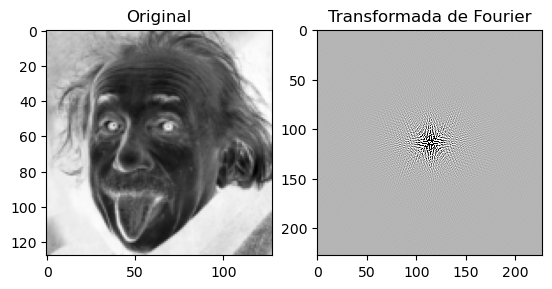

In [21]:
# Leemos la imagen y la guardamos en un Numpy array
img = Image.open("einstein.jpg")

# Convertimos nuestra imagen a un Tensor de PyTorch
process = transforms.Compose([transforms.ToTensor(), transforms.CenterCrop((2500, 2500)), transforms.Resize((128, 128))])
img = process(img)
img = img / img.max()

# Convertimos la imagen a escala de grises
img = rgb_to_grayscale(img)

# Definimos una máscara circular con el borde suave para evitar artefactos en la transformada de Fourier y la aplicamos a la imagen
padded_img = F.pad(img, (50, 50, 50, 50), mode="reflect")
mask = create_smooth_circular_mask(padded_img.shape, 0.45 * padded_img.shape[-1], smooth_width=10.0, device="cpu")
padded_img = padded_img * mask

# Generamos nuestra transformación
ft_img = torch.fft.fft2(padded_img)

# Mostramos las dos imágenes
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img.numpy()[0], cmap="gray_r")
ax[0].set_title("Original")
ax[1].imshow(torch.fft.fftshift(ft_img).real[0].numpy(), cmap="gray_r", vmax=0.01 * ft_img.real.max(), vmin=0.01 * ft_img.real.min())
ax[1].set_title("Transformada de Fourier")
plt.show()


A continuación vamos a definir nuestro PyTorch ``Dataset``. En esta ocasión, vamos a definir un tipo de red conocida como **red neuronal implícita**. Este tipo de redes tienen como objetivo aproximar una señal discreta (como una imagen) a partir de una función contínua. Dado que la función que estimamos es contínua, este tipo de redes se han vuelto muy populares para hacer reescalado de imágenes y en técnicas de super-resolución.

En nuestro caso, vamos a definir una red tal que, dada la coordenada física de un pixel ``(x,y)``, la red aprenda a determinar el valor de es pixel en la imagen. Por lo tanto, el input de nuestra red será un conjunto de coordenadas de diferentes píxeles.

Suguiendo la idea anterior, vamos a definir nuestro ``Dataset``.

In [22]:
class PixelCoordinatesDataset(Dataset):
    def __init__(self, image_shape):  # image_shape puede ser (H, W) o (C, H, W)
        super().__init__()
        if len(image_shape) == 3:  # C, H, W
            self.height = image_shape[1]
            self.width = image_shape[2]
        elif len(image_shape) == 2:  # H, W
            self.height = image_shape[0]
            self.width = image_shape[1]
        else:
            raise ValueError("image_shape not recognized. Should be (H,W) or (C,H,W)")

        # Creamos una malla de coordenadas (x,y) normalizadas entre -0.5 y 0.5
        y_coords = torch.arange(self.height, dtype=torch.float32)
        x_coords = torch.arange(self.width, dtype=torch.float32)
        y_coords_norm = (y_coords - self.height) / self.height
        x_coords_norm = (x_coords - self.width) / self.width

        # Indexamos las parejas como (y,x)
        grid_y, grid_x = torch.meshgrid(y_coords, x_coords, indexing='ij')  # ij nos da (row, col)
        grid_y_norm, grid_x_norm = torch.meshgrid(y_coords_norm, x_coords_norm, indexing='ij')  # ij nos da (row, col)
        self.coordinates = torch.stack((grid_x, grid_y), dim=-1).reshape(-1, 2).type(torch.int)  # Guardamos como (x, y)
        self.coordinates_norm = torch.stack((grid_x_norm, grid_y_norm), dim=-1).reshape(-1, 2)  # Guardamos como (x_norm, y_norm)

    def __len__(self):
        return len(self.coordinates)

    def __getitem__(self, idx):
        return self.coordinates[idx], self.coordinates_norm[idx]

En esta arquitectura vamos a definir un tipo de capas densas conocidas como SIREN. La particularidad de estas capas es el uso de funciones de activación sinusoidales, lo que permite aprender de una manera mucho más eficiente los detalles de una imagen. Esto se debe a la capacidad de diferenciación de la función sinusoidal, ya que se puede derivar infinitamente y la derivada coincide con un desplazamiento de la función original. Esto permite que la red pueda aprender de los gradientes de una manera mucho más precisa que con otro tipo de transformaciones.

Además de las activaciones sinusoidales, las capas ``SIREN`` tienden a tener una inicialización de pesos y sesgos algo diferente a las capas densas originales. En nuestra nueva capa, también implementaremos esta inicialización tal y como se describe en el trabajo original que introdujo este tipo de capas.

A continuación se definen tanto la nueva función de activación ``Sine`` como la capa densa que aprovecha dicha activación ``Siren``:

In [23]:
class Sine(nn.Module):
    def __init__(self, w0 = 1.):
        super().__init__()
        self.w0 = w0
    def forward(self, x):
        return torch.sin(self.w0 * x)

class Siren(nn.Module):
    def __init__(
        self,
        dim_in,
        dim_out,
        w0 = 1.,
        c = 6.,
        is_first = False,
        use_bias = True,
        activation = None,
        dropout = 0.
    ):
        super().__init__()
        self.dim_in = dim_in
        self.is_first = is_first

        weight = torch.zeros(dim_out, dim_in)
        bias = torch.zeros(dim_out) if use_bias else None
        self.init_(weight, bias, c=c, w0=w0)

        self.weight = nn.Parameter(weight)
        self.bias = nn.Parameter(bias) if use_bias else None
        self.activation = Sine(w0) if activation is None else activation
        self.dropout = nn.Dropout(dropout)

    def init_(self, weight, bias, c, w0):
        dim = self.dim_in

        w_std = (1 / dim) if self.is_first else (math.sqrt(c / dim) / w0)
        weight.uniform_(-w_std, w_std)

        if bias is not None:
            bias.uniform_(-w_std, w_std)

    def forward(self, x):
        out =  nn.functional.linear(x, self.weight, self.bias)
        out = self.activation(out)
        out = self.dropout(out)
        return out

Ahora vamos a definir nuestra red. Usaremos una arquitectura sencilla de capas densas con skip connections para simplificar la arquitectura:

In [24]:
class ResLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResLayer, self).__init__()
        self.dense = Siren(in_channels, out_channels, w0=30., c=6., is_first = False)

    def forward(self, x):
        return x + self.dense(x)

class ResNet(nn.Module):
    def __init__(self, num_hidden_layers: int):
        super(ResNet, self).__init__()
        self.first_layer = Siren(2, 256, c=6., w0=30., is_first=True)
        self.dense_layers = nn.ModuleList([ResLayer(256, 256) for _ in range(num_hidden_layers)])
        self.last_layer = nn.Linear(256, 1)
        # self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.first_layer(x)
        for layer in self.dense_layers:
            x = layer(x)
        return self.sigmoid(self.last_layer(x))

Una vez definida la red, continuaremos con nuestro loop de entrenamiento. En este loop, veremos que tenemos dos partes diferenciadas:

- Una primera parte que llama a nuestra red para predecir los valores de los pixeles de una imagen
- Una segunda parte con un "módulo" no entrenable que tomará la imagen anterior y calculará su transformada de Fourier

Esta segunda imagen será comparada con la transformada de Fourier de la imagen original. De esta manera, le estaremos indicando a nuestra red que la imagen que tiene que aprender a generar es la inversa de la imagen transformada.

In [25]:
def train(img, mask, ft_img, config, training_fraction=0.1, checkpoint_path: str=None):
    # Aseguramos que ft_image y mask esté en la GPU
    ft_img = ft_img.to(DEVICE)
    mask = mask.to(DEVICE)

    # Generamos el DataLoader
    dataloader = DataLoader(PixelCoordinatesDataset(img.shape), batch_size=config["batch_size"], shuffle=True, num_workers=4)

    model = ResNet(num_hidden_layers=5)
    model = model.to(DEVICE)

    optimizer = optim.AdamW(model.parameters(), lr=config["lr"])
    if checkpoint_path is not None and os.path.isdir(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['weights'])
        optimizer.load_state_dict(checkpoint['optimizer'])
    elif checkpoint_path is not None and not os.path.isdir(checkpoint_path):
        os.makedirs(checkpoint_path)
    criterion = nn.L1Loss(reduction='mean')

    # Barra de progreso
    epochs_bar = tqdm(total=config["epochs"], dynamic_ncols=True,
                      leave=False, position=0, desc="Train")

    # Training steps
    training_steps = int(training_fraction * len(dataloader.dataset) / config["batch_size"]) + 1

    for i in range(config["epochs"]):
        total_loss = 0
        predicted_img = torch.zeros(img.shape, device=DEVICE, dtype=torch.float32)
        for bidx, [x, x_norm] in enumerate(dataloader):
            x = x.to(DEVICE)
            x_norm = x_norm.to(DEVICE)
            if bidx < training_steps:
                values = model(x_norm)
            else:
                with torch.no_grad():
                    values = model(x_norm)
            predicted_img[0, x[..., 1], x[..., 0]] += torch.squeeze(values)
        predicted_img = F.pad(predicted_img, (50, 50, 50, 50), mode="reflect") * mask
        predicted_ft_img = torch.fft.fft2(predicted_img)  # Esta operación permite a la red aprender de nuestro conocimiento sobre la transformada de Fourier
        optimizer.zero_grad()
        loss = criterion(predicted_ft_img.real, ft_img.real) + criterion(predicted_ft_img.imag, ft_img.imag)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        epochs_bar.set_postfix(
            loss=f"{total_loss/len(dataloader):.6f}",
            lr = f"{optimizer.param_groups[0]['lr']:.4f}"
        )
        epochs_bar.update()

    checkpoint = {
        'weights': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    if checkpoint_path is not None:
        torch.save(checkpoint, os.path.join(checkpoint_path, "checkpoint.pth"))

El siguiente paso consiste en entrenar nuestra red usando la función anterior:

In [26]:
    if os.path.isdir(os.path.join('checkpoints')):
        shutil.rmtree(os.path.join('checkpoints'))
    train(img, mask, ft_img, config, checkpoint_path=os.path.join('checkpoints', 'phys_net'))

Train:   0%|          | 0/5000 [00:00<?, ?it/s]

Por último, definimos la función para recargar nuestra red e inferir la imagen entrenada:

In [27]:
def inference(img_shape: list, checkpoint_path: str=None):
    checkpoint = torch.load(os.path.join(checkpoint_path, "checkpoint.pth"))

    model = ResNet(num_hidden_layers=5)
    model = model.to(DEVICE)
    model.load_state_dict(checkpoint['weights'])

    # Generamos el DataLoader
    dataloader = DataLoader(PixelCoordinatesDataset(img_shape), batch_size=config["batch_size"], shuffle=True)

    predicted_img = torch.zeros(img_shape, device=DEVICE, dtype=torch.float32)
    with torch.no_grad():
        for bidx, [x, x_norm] in enumerate(dataloader):
            x = x.to(DEVICE)
            x_norm = x_norm.to(DEVICE)
            values = model(x_norm)
            predicted_img[x[..., 1], x[..., 0]] += torch.squeeze(values)

    return predicted_img.cpu().numpy()

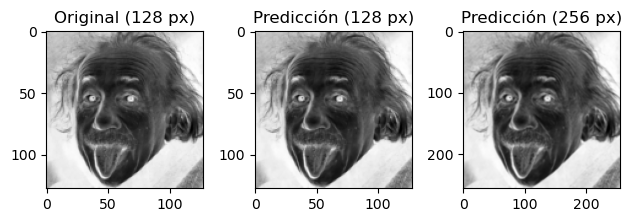

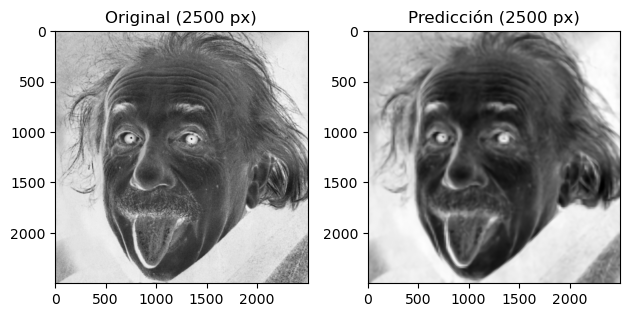

In [28]:
predicted_img = inference([128, 128], os.path.join('checkpoints', 'phys_net'))
predicted_img_upscaled = inference([256, 256], os.path.join('checkpoints', 'phys_net'))
predicted_img_upscaled_2 = inference([2500, 2500], os.path.join('checkpoints', 'phys_net'))

# Imagen a tamaño original
img_original_size = Image.open("einstein.jpg")

# Convertimos nuestra imagen a un Tensor de PyTorch
process = transforms.Compose([transforms.ToTensor(), transforms.CenterCrop((2500, 2500))])
img_original_size = process(img_original_size)
img_original_size = img_original_size / img_original_size.max()

# Comparamos la imagen original y la predicción
fig, ax = plt.subplots(1, 3)
ax[0].imshow(img.numpy()[0], cmap="gray_r")
ax[0].set_title("Original (128 px)")
ax[1].imshow(predicted_img, cmap="gray_r")
ax[1].set_title("Predicción (128 px)")
ax[2].imshow(predicted_img_upscaled, cmap="gray_r")
ax[2].set_title("Predicción (256 px)")
plt.tight_layout()
plt.show()

# Comparamos la imagen original y la predicción
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img_original_size.numpy()[0], cmap="gray_r")
ax[0].set_title("Original (2500 px)")
ax[1].imshow(predicted_img_upscaled_2, cmap="gray_r")
ax[1].set_title("Predicción (2500 px)")
plt.tight_layout()
plt.show()